In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
alexnet, cnn_model = mmsom.create_cnn_model()

In [4]:
tokens = pd.read_table('/data/master_thesis/Flickr8k.lemma.token.txt',
                       names=['fname', 'doc'], index_col='fname', )
tokens['fname'] = tokens.index.str.replace(r'#\d', '')
tokens.head()

,doc,fname
fname,,
1305564994_00513f9a5b.jpg#0,A man in street racer armor be examine the tir...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#1,Two racer drive a white bike down a road .,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#2,Two motorist be ride along on their vehicle th...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#3,Two person be in a small race car drive by a g...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#4,Two person in race uniform in a street car .,1305564994_00513f9a5b.jpg


In [5]:
len(tokens.fname.value_counts())

8092

In [6]:
vec2word_fname = Path('vec2word.csv')
if vec2word_fname.exists():
    vec2word = pd.read_csv(vec2word_fname)
else:
    words = set()
    for doc in tokens.doc:
        words |= set(map(str.strip, map(str.lower, doc.split())))
    vec2word = [token for word in words for token in nlp(word)]
    vec2word = [list(token.vector) + [token.orth_] for token in vec2word
                if token.pos_ in ('NOUN', 'PROPN')]
    vec2word = pd.DataFrame(vec2word, columns=[f'vector_{i}' for i in range(300)] + ['word'])
    groups = vec2word.groupby('word')
    vec2word = pd.concat((groups.transform('mean'), vec2word.word), axis=1)
    vec2word = vec2word.drop_duplicates()
    vec2word.to_csv(vec2word_fname, index=False)
vec2word.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_291,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,word
0,-0.817450,0.13404,0.233550,-0.273360,-0.136910,0.94338,-0.10316,0.211570,-0.58204,0.68200,...,0.079486,-0.163030,-0.289800,-0.751070,0.292390,0.154300,-0.857900,0.366390,0.060845,vegetable
1,-0.096463,0.12389,-0.286050,0.052724,0.208880,-0.18169,-0.26443,-0.047206,0.16012,2.30010,...,0.081946,0.475360,-0.028736,-0.280950,-0.226700,0.108060,0.053104,0.072041,-0.305380,up
2,-0.128590,-0.34514,-0.149370,0.290590,-0.327000,-0.52534,0.29771,-0.138790,-0.38140,0.17711,...,-0.279110,0.091394,0.100390,-0.452040,0.058716,0.429980,-0.221450,0.043477,0.340290,fluorescent
3,0.574690,0.62430,-0.239960,0.299560,0.335710,-0.14272,0.41671,0.123510,0.15892,1.10650,...,-0.192990,0.338470,-0.392470,0.045151,0.201740,0.221950,0.621240,-0.554640,0.427770,javelin
4,0.238670,-0.19234,0.085205,-0.249650,-0.013303,-0.21243,-0.16933,0.854740,0.15946,2.53180,...,0.351450,0.273070,0.185790,-0.051780,0.418070,-0.098351,0.245300,-0.086568,0.341490,vision


In [7]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_word/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
groups = test_captions.groupby('fname')
test_captions = pd.concat((test_captions,
                           groups.rank().rename(columns={'doc': 'doc_rank'}).astype(int)),
                          axis=1)\
                  .sort_values(['fname', 'doc_rank'])
test_captions.head()

,fname,doc,doc_rank
2475,101669240_b2d3e7f17b.jpg,A man in a hat be display picture next to a sk...,1
2476,101669240_b2d3e7f17b.jpg,A man ski past another man display painting in...,2
2477,101669240_b2d3e7f17b.jpg,A person wear ski look at framed picture set u...,3
2478,101669240_b2d3e7f17b.jpg,A skier look at framed picture in the snow nex...,4
2479,101669240_b2d3e7f17b.jpg,Man on ski look at artwork for sale in the snow,5


In [8]:
train_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_word/train_captions.csv')
train_captions = pd.read_csv(train_captions_fname)
groups = train_captions.groupby('fname')
train_captions = pd.concat((train_captions,
                           groups.rank().rename(columns={'doc': 'doc_rank'}).astype(int)),
                          axis=1)\
                   .sort_values(['fname', 'doc_rank'])
train_captions.head()

,fname,doc,doc_rank
27860,1000268201_693b08cb0e.jpg,A child in a pink dress be climb up a set of s...,1
27861,1000268201_693b08cb0e.jpg,A girl go into a wooden building .,2
27862,1000268201_693b08cb0e.jpg,A little girl climb into a wooden playhouse .,3
27863,1000268201_693b08cb0e.jpg,A little girl climb the stair to her playhouse .,4
27864,1000268201_693b08cb0e.jpg,A little girl in a pink dress go into a wooden...,5


In [8]:
vec2img_fname = Path('vec2img.csv')
if vec2img_fname.exists():
    vec2img = pd.read_csv(vec2img_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img = []
    for fname in tqdmn(list(img_dir.glob('*.jpg'))):
        vec2img.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img = pd.DataFrame(
        vec2img, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img = vec2img.set_index('fname')
    vec2img.to_csv(vec2img_fname)
vec2img.head()

HBox(children=(IntProgress(value=0, max=8091), HTML(value='')))

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/937559727_ae2613cee5.jpg,0.0,0.000000,0.0,0.000000,0.000000,0.403997,0.393894,1.118510,0.0,0.101588,...,0.000000,0.0,0.707124,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/241374292_11e3198daa.jpg,0.0,0.000000,0.0,0.296849,0.000000,0.000000,0.242252,0.485355,0.0,0.000000,...,0.000000,0.0,0.000000,0.784749,0.00000,0.0,0.000000,0.0,0.186664,0.000000
/data/master_thesis/Flickr8k_Dataset/3046949818_245b05f507.jpg,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.322675,0.0,0.000000,1.958778
/data/master_thesis/Flickr8k_Dataset/2590207488_ddd89037ba.jpg,0.0,3.717371,0.0,0.000000,0.971882,0.581446,2.899131,0.000000,0.0,0.000000,...,0.585796,0.0,0.000000,0.000000,0.31789,0.0,0.000000,0.0,0.000000,2.286348
/data/master_thesis/Flickr8k_Dataset/1931690777_897a7d8ab6.jpg,0.0,0.000000,0.0,0.924577,0.580005,0.000000,2.660403,0.000000,0.0,0.000000,...,2.824198,0.0,0.000000,0.000000,0.00000,0.0,0.176784,0.0,0.187771,0.217623


In [9]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

In [10]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/3666537170_c4ecda4be8.jpg,0.000000,0.00000,0.000000,2.518639,0.325627,0.000000,2.549387,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,4.559406,0.0,0.000000,1.147152
/data/master_thesis/Flickr8k_Dataset/3728164558_52729baefa.jpg,0.000000,0.00000,0.236677,0.000000,2.801900,0.000000,0.000000,0.0,0.0,0.015301,...,0.605277,0.0,0.0,3.674644,1.169416,0.0,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/3009018821_ba47396e24.jpg,0.000000,0.00000,0.000000,4.033770,0.000000,0.000000,3.700997,0.0,0.0,0.000000,...,0.465184,0.0,0.0,0.000000,0.000000,0.0,0.036659,0.0,2.384023,0.000000
/data/master_thesis/Flickr8k_Dataset/2441313372_6a1d59582b.jpg,0.000000,0.67627,0.000000,1.237902,0.859647,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.506513,0.000000
/data/master_thesis/Flickr8k_Dataset/3459858555_c3f0087a72.jpg,1.739641,0.00000,1.595610,1.707735,0.000000,0.480012,0.000000,0.0,0.0,0.000000,...,0.885898,0.0,0.0,1.410513,0.000000,0.0,0.624201,0.0,0.000000,0.000000


In [11]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(model.som_model.codebook.reshape(10000, 4396))

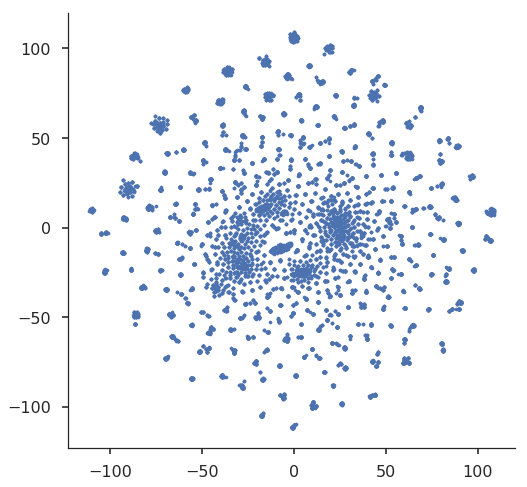

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter(*projection.T, s=10)
sns.despine()

In [14]:
vec2img_test /= 4096

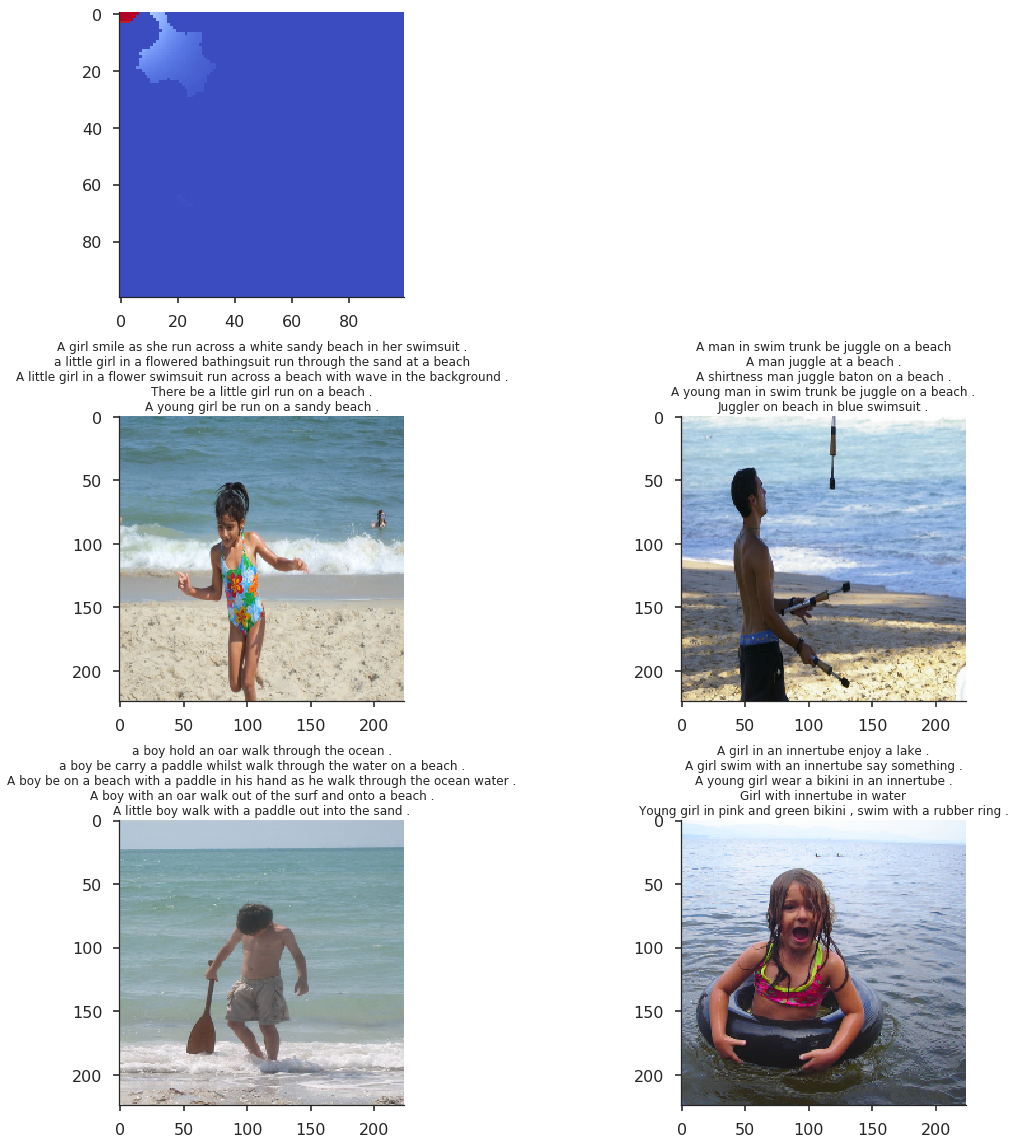

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()
knn_ids = model.get_knn_images(doc='dog water', k=4, vec2img=vec2img_test, ax=axes[0])
knn = vec2img_test.index[knn_ids]
for ax, fname in zip(axes[2:], knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    ax.imshow(img)
    ax.set_title('\n'.join(tokens.loc[tokens.fname.str.contains(fname.name), 'doc']),
                 fontsize=12)
fig.delaxes(axes[1])
sns.despine()
plt.tight_layout()

In [16]:
test_words_fname = Path('test_words.csv')
if test_words_fname.exists():
    test_words = pd.read_csv(test_words_fname)
else:
    test_words = []
    for _, row in tqdmn(test_captions.iterrows(), total=len(test_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.doc.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            test_words.append((row.fname, row.doc_rank, word))
    test_words = pd.DataFrame(test_words, columns=('fname', 'doc_rank', 'word'))
    test_words = test_words.drop_duplicates().reset_index(drop=True)
    test_words.to_csv(test_words_fname, index=False)
print(len(test_words))
print(len(test_words.drop_duplicates()))
test_words.head()

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))


15173
15173


,fname,doc_rank,word
0,101669240_b2d3e7f17b.jpg,1,picture
1,101669240_b2d3e7f17b.jpg,1,hat
2,101669240_b2d3e7f17b.jpg,1,display
3,101669240_b2d3e7f17b.jpg,1,skier
4,101669240_b2d3e7f17b.jpg,2,display


In [3]:
train_words_fname = Path('train_words.csv')
if train_words_fname.exists():
    train_words = pd.read_csv(train_words_fname)
else:
    train_words = []
    for _, row in tqdmn(train_captions.iterrows(), total=len(train_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.doc.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            train_words.append((row.fname, row.doc_rank, word))
    train_words = pd.DataFrame(train_words, columns=('fname', 'doc_rank', 'word'))
    train_words = train_words.drop_duplicates().reset_index(drop=True)
    train_words.to_csv(train_words_fname, index=False)
print(len(train_words))
print(len(train_words.drop_duplicates()))
train_words.head()

108490
108490


,fname,doc_rank,word
0,1000268201_693b08cb0e.jpg,1,way
1,1000268201_693b08cb0e.jpg,1,child
2,1000268201_693b08cb0e.jpg,1,entry
3,1000268201_693b08cb0e.jpg,1,stair
4,1000268201_693b08cb0e.jpg,2,girl


In [17]:
len(test_words.fname.unique())

1000

In [18]:
results_words = {}
for _, row in tqdmn(test_words.iterrows(), total=len(test_words)):
    fname, doc_rank, word = row
    knn_ids = model.get_knn_images(doc=word, k=20, vec2img=vec2img_test)
    knn = vec2img_test.index[knn_ids]
    results_words[(fname, doc_rank, word)] = knn.copy()

HBox(children=(IntProgress(value=0, max=15173), HTML(value='')))

In [19]:
import pickle

with open('results_words_norm2.pickle', 'wb') as fp:
    pickle.dump(results_words, fp)

In [2]:
import pickle

with open('results_words_norm2.pickle', 'rb') as fp:
    results_words = pickle.load(fp)

In [20]:
np.mean([1 if fname in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.001120411256837804

In [21]:
np.mean([1 if fname in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.001845383246556383

In [22]:
np.mean([1 if fname in r[:5].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.004942990838990312

In [23]:
np.mean([1 if fname in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.010281420945099849

In [24]:
np.mean([1 if fname in r[:20].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.020299215712120212